<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        print("who is q ", q)
        # Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        #print(S_inv.shape)
        #print("S_inv ", S_inv)
        partial = S_inv @ param  # should be (m * n,)
        if S_inv.shape == (n, n):
          print("one matrix in input, S_inv.shape = (n, n)")
          param_norm = cp.pnorm(partial, p=q)
        else:  # should be a stack of matrix
          print("multiple matrices in input, S_inv conc")
          #print("shape partial 1", partial.shape)
          partial = cp.reshape(partial, (m, n), order='C')
          #print("shape partial ", partial.shape)
          param_norm = cp.pnorm(partial, p=q, axis=1)
        #print("param_norm.shape", param_norm.shape)
        #print("param_norm\n", param_norm)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False


    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_inv, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_inv, p=np.inf)
    estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
    alphas_adv, coefs_advtrain_linf  = get_path(X, y, estimator, 1e1)
    plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
    plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return coefs_advtrain_linf


def add_rectangles(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 0.1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)


#def add_rectangles(x, y, box_width, box_height, ax):
#  for xi, yi in zip(x, y):
#      rect = patches.Rectangle(
#        (xi-box_width/2, yi-box_height/2),
#        box_width, box_height,
#        linewidth=1, edgecolor='r', facecolor='none'
#      )
#      ax.add_patch(rect)

print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [156]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       if nbr_mi == 1:
        res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [ ]:
# define observations
np.random.seed(45)
n_observationsss = 300
dim = 10
#cov = np.random.randint(low=1, high=10, size=(d, d))
#cov = np.random.randn(d, d)
#cov = cov.T @ cov + np.eye(dim) * 1e-5
#print(cov)
#print(np.linalg.eigvalsh(cov))
cov = np.eye(dim)
X_orig = np.random.rand(n_observationsss, dim) @ cov
#X_orig = np.random.randint(low=1, high=4, size=(n, d)) * 1.0
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(dim)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n_observationsss, dim))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
n_observationsss = X_orig.shape[0]
print("shape ", X_orig.shape)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
print("end block")

shape  (300, 10)
final shape  (300, 10)
end block


In [ ]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

In [ ]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
sd_orig = np.std(X_orig, axis=0)
print("sd_orig \n", sd_orig)
S_inv_orig = np.diag(1 / sd_orig)
#S_inv_orig = np.eye(dim)
S_inv_orig = np.array([S_inv_orig] * n_observationsss)
S_inv_orig = np.concatenate(S_inv_orig)
print("S_inv_orig.shape ", S_inv_orig.shape)
test = S_inv_orig @ np.arange(dim)
#print("test mult\n", test)
#print("test reshape \n", test.reshape(n_observationsss, dim, order='C'))
#print(S_inv_orig)
#S_inv_orig = np.diag(1 / sd_orig)
#print("S_inv_orig shape\n ", S_inv_orig.shape)
#S_inv_orig = np.eye(X_orig.shape[0])
linfadvtrain = AdversarialTraining(X_orig, y, S_inv_orig, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf, ax)

In [157]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    # p_missing = [0.3, 0.3, 0.4]
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  #print("shape X ", X.shape)
  #print("shape coeff ", coeff.shape)
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  #print("shape y ", y.shape)
  #print("size haty ", hat_y.shape)
  #print("haty ", hat_y)
  #print("y ", y)
  r = hat_y - y  # residual
  #print("size r ", r.shape)
  #print("r ", r)
  score = np.mean(r * r, axis=1)
  #print("size score ", score.size)
  #print("scores ", score)
  i_min = np.argmin(score)
  #print("i_min ", i_min)
  #print("best predictor, coeff i_min ")
  return coeff[:, i_min], score[i_min]


def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


def experiment_2d(n_tot, perc_test, p_miss, beta_gt, ax):

    #fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf_2d')
    X_complete = np.random.randn(n_tot, beta_gt.size)
    y_complete = X_complete @ beta_gt + np.random.randn(n_tot) * 1e-1
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)

    n_train, n_test = X_train.shape[0], X_test.shape[0]
    mask = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component
    print(M.size)
    print("nbr components without missing entries ", np.sum(1-M))
    #print("print M, M[i] == 1 iff one component is missing", M)

    X_masked = X_train * (1 - mask)

    X_nan_train = X_train.copy()
    X_nan_train[mask == 1] = np.nan

    X_br_train = single_imputation(X_nan_train, BayesianRidge())
    sd = np.std(X_br_train, axis=0)
    print("shape X_bri Train ", X_br_train.shape)
    print("sd deviation columnwise: ", sd)

    S_inv = np.diag(1 / sd) * 1
    plt.tight_layout()
    #print(X_br_train[M == 0, 0])
    ax[0].scatter(X_br_train[M == 0, 0], X_br_train[M == 0, 1])
    ax[0].scatter(X_br_train[M == 1, 0], X_br_train[M == 1, 1])
    add_rectangles(X_br_train[:, 0], X_br_train[:, 1], S_inv[0, 0], S_inv[1, 1], ax[0])

    coeff_res = train_and_plot(X_br_train, y_train, S_inv, [ax[1], ax[2]])
    print("shape coeff ", coeff_res.shape)
    best_coeff, min_score = best_predictor(X_test, coeff_res, y_test)
    print("best coeff ", best_coeff)
    print("min score ", min_score)
    #plt.show()
    return best_coeff, min_score


[-0.5  2. ]
iteration  0
80
nbr components without missing entries  39.0
shape X_bri Train  (80, 2)
sd deviation columnwise:  [1.02555531 0.79745741]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[0.97508149 0.        ]
 [0.         1.25398546]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[0.98 0.00]
 [0.00 1.25]] @ var1)
ciao2
abs_error.shape  (80,)
ciao3
ciao4


100%|██████████| 200/200 [00:01<00:00, 134.88it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (20, 2)
shape coeff  (2, 200)
shape y  (20,)
size haty  (200, 20)
size r  (200, 20)
size score  200
i_min  99
best predictor, coeff i_min 
best coeff  [-0.09155106  1.88684522]
min score  0.2516462547093515
best coeff  [-0.09155106  1.88684522]
min score  0.2516462547093515
iteration  1
400
nbr components without missing entries  256.0
shape X_bri Train  (400, 2)
sd deviation columnwise:  [0.8718476  0.91574665]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.14698945 0.        ]
 [0.         1.09200509]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.15 0.00]
 [0.00 1.09]] @ var68)
ciao2
abs_error.shape  (400,)
ciao3
ciao4


100%|██████████| 200/200 [00:03<00:00, 56.10it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (100, 2)
shape coeff  (2, 200)
shape y  (100,)
size haty  (200, 100)
size r  (200, 100)
size score  200
i_min  104
best predictor, coeff i_min 
best coeff  [-0.43158864  1.98068353]
min score  0.01344788579651536
best coeff  [-0.43158864  1.98068353]
min score  0.01344788579651536
iteration  2
600
nbr components without missing entries  364.0
shape X_bri Train  (600, 2)
sd deviation columnwise:  [0.84302387 0.84175774]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.18620604 0.        ]
 [0.         1.18799027]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.19 0.00]
 [0.00 1.19]] @ var135)
ciao2
abs_error.shape  (600,)
ciao3
ciao4


100%|██████████| 200/200 [00:04<00:00, 44.55it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (150, 2)
shape coeff  (2, 200)
shape y  (150,)
size haty  (200, 150)
size r  (200, 150)
size score  200
i_min  100
best predictor, coeff i_min 
best coeff  [-0.43578967  1.9771566 ]
min score  0.018515587092523135
best coeff  [-0.43578967  1.9771566 ]
min score  0.018515587092523135
final coeff 
 [[-0.09155106 -0.43158864 -0.43578967]
 [ 1.88684522  1.98068353  1.9771566 ]]
final scores 
  [0.25164625 0.01344789 0.01851559]


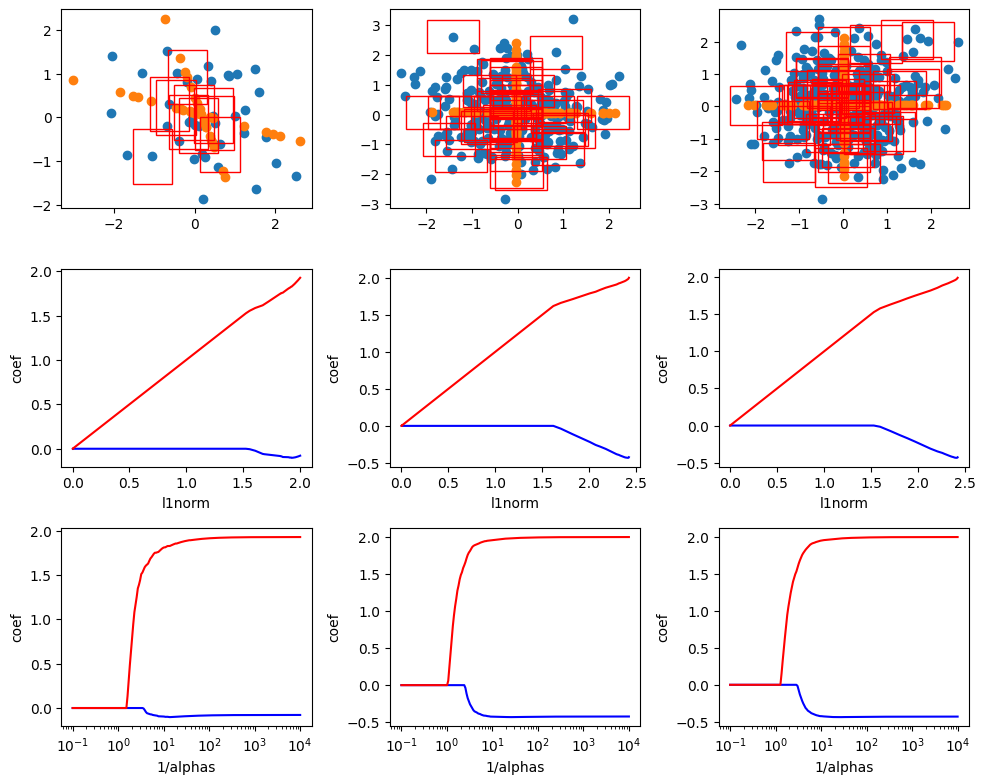

In [ ]:
np.random.seed(43)
list_tot = [100, 500, 750]
l = len(list_tot)
p_miss_2d = [0.6, 0.2, 0.2]
#beta_2d = np.random.randn(2)
beta_2d = np.array([-0.5, 2])
print(beta_2d)
scores_fin = np.zeros(l)
coeff_fin = np.zeros((2, l))

fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d')

for i in range(l):
    print("iteration ", i)
    n_tot = list_tot[i]
    best_coeff_round, min_score_round = experiment_2d(n_tot, 0.2, p_miss_2d, beta_2d, ax[:, i])
    print("best coeff ", best_coeff_round)
    print("min score ", min_score_round)
    coeff_fin[:, i] = best_coeff_round
    scores_fin[i] = min_score_round
print("final coeff \n", coeff_fin)
print("final scores \n ", scores_fin)



ground truth  [-0.5  2. ]
--------> iteration  0


TypeError: 'float' object is not subscriptable

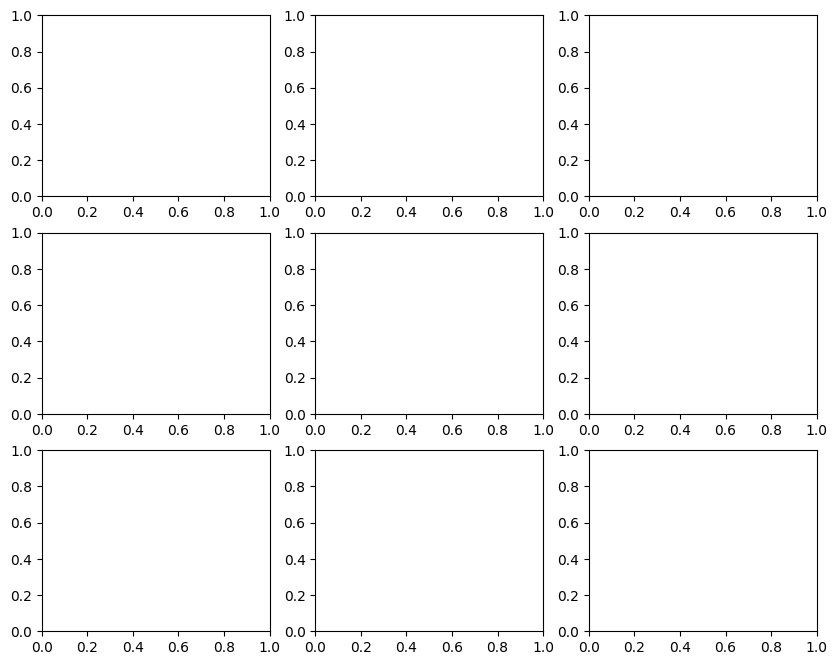

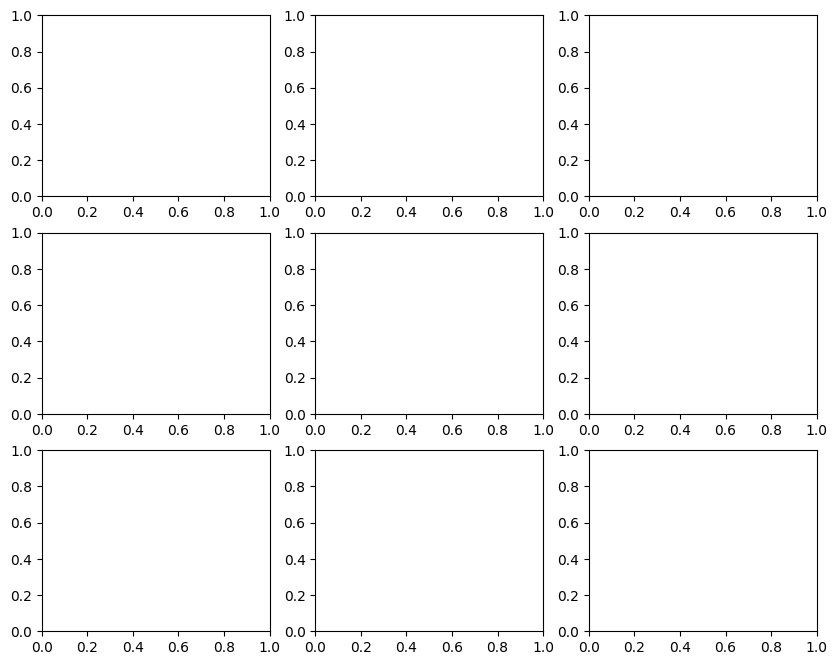

In [158]:
np.random.seed(43)
list_tot = [750, 1000, 2000]  # 750, 1000, 2000
l = len(list_tot)
p_miss_2d = [0.1, 0.45, 0.45]  # 0.1, 0.45, 0.45
#beta_2d = np.random.randn(2)
beta_2d = np.array([-0.5, 2])
print("ground truth ", beta_2d)
scores_fin = np.zeros(l)
coeff_fin = np.zeros((2, l))
scores_fin_ld = np.zeros(l)
coeff_fin_ld = np.zeros((2, l))

p_test = 0.2  # 0.2
err_2d = 2.5  # 5
fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d')
fig1, ax1 = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d1')


for i in range(l):
    print("--------> iteration ", i)
    n_total = list_tot[i]
    dict_obser = generate_dataset(data='Gaussian', n_tot=n_total, dim=2, beta_gt=beta_2d, perc_test=p_test, p_miss=p_miss_2d, err=err_2d)
    best_coeff_round, min_score_round = experiment_2d_ext_dataset(dict_obser, ax[:, i])
    print("best coeff ", best_coeff_round, "\n min score ", min_score_round)
    coeff_fin[:, i] = best_coeff_round
    scores_fin[i] = min_score_round
    #print(dict_obser)
    # deep_copied = copy.deepcopy(original)
    dict_obser['X_train'] = listwise_delection(dict_obser['X_train'], dict_obser['masks_train'])
    dict_obser['y_train'] = listwise_delection(dict_obser['y_train'], dict_obser['masks_train'])
    dict_obser['masks_train'] = np.zeros_like(dict_obser['X_train'])
    #print(dict_obser)
    best_coeff_round_ld, min_score_round_ld = experiment_2d_ext_dataset(dict_obser, ax1[:, i])
    coeff_fin_ld[:, i] = best_coeff_round_ld
    scores_fin_ld[i] = min_score_round_ld

print("final coeff \n", coeff_fin.T)
print("final scores \n ", scores_fin)

print("final coeff \n", coeff_fin_ld.T)
print("
##  bayesian imputation + robust opt vs listwise delection

final scores \n ", scores_fin_ld)


In [159]:
# experiment 2d with dataset generated externally

def imputations(info, X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BayesianRidge_single_imp':
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] == 'mi':
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'listwise_deletion':
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        mask_from_X_nan = np.zeros_like(X)
    return X, y, mask_from_X_nan


def cov_strategy(info, X_imputed):
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #S_inv = np.diag(1 / sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S_inv = np.diag(sd)
    if info['cov_strategy'] == 'eye':
      S_inv = np.eye(X_imputed.shape[1])
    return S_inv


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    if data == 'Gaussian':
      X_complete = np.random.randn(n_tot, beta_gt.size)
    elif data == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['kind'] == 'Gaussian':
      print("--------------------------------------> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['kind'] == 'Uniform':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used
    # ax contains info for the plots

    #fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf_2d')
    #X_complete = np.random.randn(n_tot, beta_gt.size)
    #y_complete = X_complete @ beta_gt + np.random.randn(n_tot) * 1e-1
    #X_train = dict_obs['X_train']
    X_test = dict_obs['X_test']
    #y_train = dict_obs['y_train']
    y_test = dict_obs['y_test']
    mask = dict_obs['masks_train']
    #X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)

     #mask = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component
    #print(M.size)
    print("nbr components without missing entries ", np.sum(1-M))
    #print("print M, M[i] == 1 iff one component is missing", M)

    #X_masked = X_train * (1 - mask)

    X_nan_train = dict_obs['X_train'].copy()
    X_nan_train[mask == 1] = np.nan
    print("dict imp -----> ", dict_imp)
    X_train, y_train, mask_train = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
    n_train, n_test = X_train.shape[0], X_test.shape[0]
    M = np.sum(mask_train, axis=1)  # M[i] > 0 iff i has missing component
    print("-------> size train: ", n_train, " size test: ", n_test)
    print("M size ", M.size)
    print("M ", M)

    S_inv = cov_strategy(dict_imp, X_train)
    #if dict_imp['kind'] == 'BayesianRidge_single_imp':
    #  X_br_train = single_imputation(X_nan_train, BayesianRidge())
    #elif dict_imp['kind'] == 'mi':
    #  X_br_train = single_imputation(X_nan_train, IterativeImputer())

    #sd = np.std(X_br_train, axis=0)
    #print("shape X_bri Train ", X_br_train.shape)
    #print("sd deviation columnwise:------------>", sd)

    #if dict_imp['cov'] == 'sd':
    #  S_inv = np.diag(1 / sd)
    #elif dict_imp['cov'] == 'eye':
    #  S_inv = np.eye(X_train.shape[1])

    print("-----------> ", ax, type(ax))


    plt.tight_layout()
    #print(X_br_train[M == 0, 0])
    ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
    ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
    add_rectangles(X_train[:, 0], X_train[:, 1], S_inv[0, 0], S_inv[1, 1], ax[0])

    coeff_results = train_and_plot(X_train, y_train, S_inv, [ax[1], ax[2]])
    print("shape coeff ", coeff_results.shape)
    best_coeff, min_score = best_predictor(X_test, coeff_results, y_test)
    print("best coeff ", best_coeff)
    print("min score ", min_score)
    #plt.show()
    return best_coeff, min_score



In [163]:

def run_experiments_old(dictio, dic_imp, methods):
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
    l = len(dictio['data'])
    scores_fin = np.zeros(l)
    coeff_fin = np.zeros((2, l))
    scores_fin_ld = np.zeros(l)
    coeff_fin_ld = np.zeros((2, l))
    fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d')
    if 'listwise_deletion' in methods:
      fig_ld, ax_ld = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d_ld')

    for i in range(l):
      print("--------> iteration ", i)
      dict_obser = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      best_coeff_round, min_score_round = experiment_2d_ext_dataset(dict_obser, dic_imp[i], ax[:, i])
      print("best coeff ", best_coeff_round, "\n min score ", min_score_round)
      coeff_fin[:, i] = best_coeff_round
      scores_fin[i] = min_score_round
      # print(dict_obser)
      # deep_copied = copy.deepcopy(original)
      if 'listwise_deletion' in methods:
        dict_obser['X_train'] = listwise_delection(dict_obser['X_train'], dict_obser['masks_train'])
        dict_obser['y_train'] = listwise_delection(dict_obser['y_train'], dict_obser['masks_train'])
        dict_obser['masks_train'] = np.zeros_like(dict_obser['X_train'])
        #print(dict_obser)
        best_coeff_round_ld, min_score_round_ld = experiment_2d_ext_dataset(dict_obser, dic_imp[i], ax_ld[:, i])
        coeff_fin_ld[:, i] = best_coeff_round_ld
        scores_fin_ld[i] = min_score_round_ld


    print("final coeff \n", coeff_fin.T)
    print("final scores \n ", scores_fin)
    if 'listwise_deletion' in methods:
      print("----> listwise del: ", "final coeff_ld\n", coeff_fin_ld.T, "\n final score_ld ", scores_fin_ld)




def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
    l = len(dictio['data'])
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))
    #fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d')    ### CHANGE THIS PART FOR PLOTTING PROPERLY (YOU CAN TRY TO MAKE JUST A BIG BIG FIGURE)
    #if 'listwise_deletion' in methods:
    #  fig_ld, ax_ld = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d_ld')

    fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(15, 15), num='advtrain_linf_')

    for i in range(l):
      print("--------> iteration ", i)
      dict_obser = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])

      for idx, info_imp_cov_dict in enumerate(methods_strategy):

        coeff_round, score_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * 3):((idx+1)*3), i])

        #X_imp = imputations(info_dict, cov_strategy, dict_obser)
        #if method == 'BayesianRidge_single_imp':
        #  best_coeff_round, min_score_round = experiment_2d_ext_dataset(dict_obser, dic_imp[i], ax[:, i])
        #  print("best coeff ", best_coeff_round, "\n min score ", min_score_round)
        #  coeff_fin[:, i] = best_coeff_round
        #  scores_fin[i] = min_score_round
      # print(dict_obser)
      # deep_copied = copy.deepcopy(original)
      #if 'listwise_deletion' in methods:
      #  dict_obser['X_train'] = listwise_delection(dict_obser['X_train'], dict_obser['masks_train'])
      #  dict_obser['y_train'] = listwise_delection(dict_obser['y_train'], dict_obser['masks_train'])
      #  dict_obser['masks_train'] = np.zeros_like(dict_obser['X_train'])
        #print(dict_obser)
      #  best_coeff_round_ld, min_score_round_ld = experiment_2d_ext_dataset(dict_obser, dic_imp[i], ax_ld[:, i])
      #  coeff_fin_ld[:, i] = best_coeff_round_ld
      #  scores_fin_ld[i] = min_score_round_ld


    #print("final coeff \n", coeff_fin.T)
    #print("final scores \n ", scores_fin)
    #if 'listwise_deletion' in methods:
    #  print("----> listwise del: ", "final coeff_ld\n", coeff_fin_ld.T, "\n final score_ld ", scores_fin_ld)











{'data': ['moons', 'moons', 'moons'], 'n_tot': [100, 250, 500], 'dim': [2, 2, 2], 'beta_gt': [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])], 'perc_test': [0.2, 0.2, 0.2], 'p_miss': [[0.8, 0.1, 0.1], [0.8, 0.1, 0.1], [0.8, 0.1, 0.1]], 'err': [{'kind': 'Gaussian', 'scaling': 2}, {'kind': 'Gaussian', 'scaling': 2}, {'kind': 'Gaussian', 'scaling': 2}]}
--------> iteration  0
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
nbr components without missing entries  66.0
dict imp ----->  {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
-------> size train:  80  size test:  20
M size  80
M  [0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0]
----------->  [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>
who is q  1
one matrix in input, S_inv.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 190.36it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
best coeff  [-0.51007215  2.57785882]
min score  3.8263477606656884
nbr components without missing entries  66.0
dict imp ----->  {'imp_method': 'listwise_deletion', 'cov_strategy': 'sd'}
-------> size train:  66  size test:  20
M size  66
M  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------->  [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>
who is q  1
one matrix in input, S_inv.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 145.23it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
best coeff  [-0.64912251  2.62741346]
min score  3.7547365902537897
--------> iteration  1
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
nbr components without missing entries  172.0
dict imp ----->  {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
-------> size train:  200  size test:  50
M size  200
M  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1]
----------->  [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>
who is q  1
one matrix in input, S_inv.shape =

100%|██████████| 200/200 [00:02<00:00, 79.50it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
best coeff  [-0.46997414  1.54804367]
min score  4.593049100972341
nbr components without missing entries  172.0
dict imp ----->  {'imp_method': 'listwise_deletion', 'cov_strategy': 'sd'}
-------> size train:  172  size test:  50
M size  172
M  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
----------->  [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>
who is q  1
one matrix in input, S_inv.shape = (

100%|██████████| 200/200 [00:01<00:00, 113.68it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
best coeff  [-0.50808523  1.51034074]
min score  4.592033045096609
--------> iteration  2
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
nbr components without missing entries  320.0
dict imp ----->  {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
-------> size train:  400  size test:  100
M size  400
M  [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

100%|██████████| 200/200 [00:02<00:00, 69.33it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
best coeff  [-0.3038242   1.97397933]
min score  4.135617279717933
nbr components without missing entries  320.0
dict imp ----->  {'imp_method': 'listwise_deletion', 'cov_strategy': 'sd'}
-------> size train:  320  size test:  100
M size  320
M  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 200/200 [00:02<00:00, 76.37it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
best coeff  [-0.28174754  1.99831226]
min score  4.123801437753957


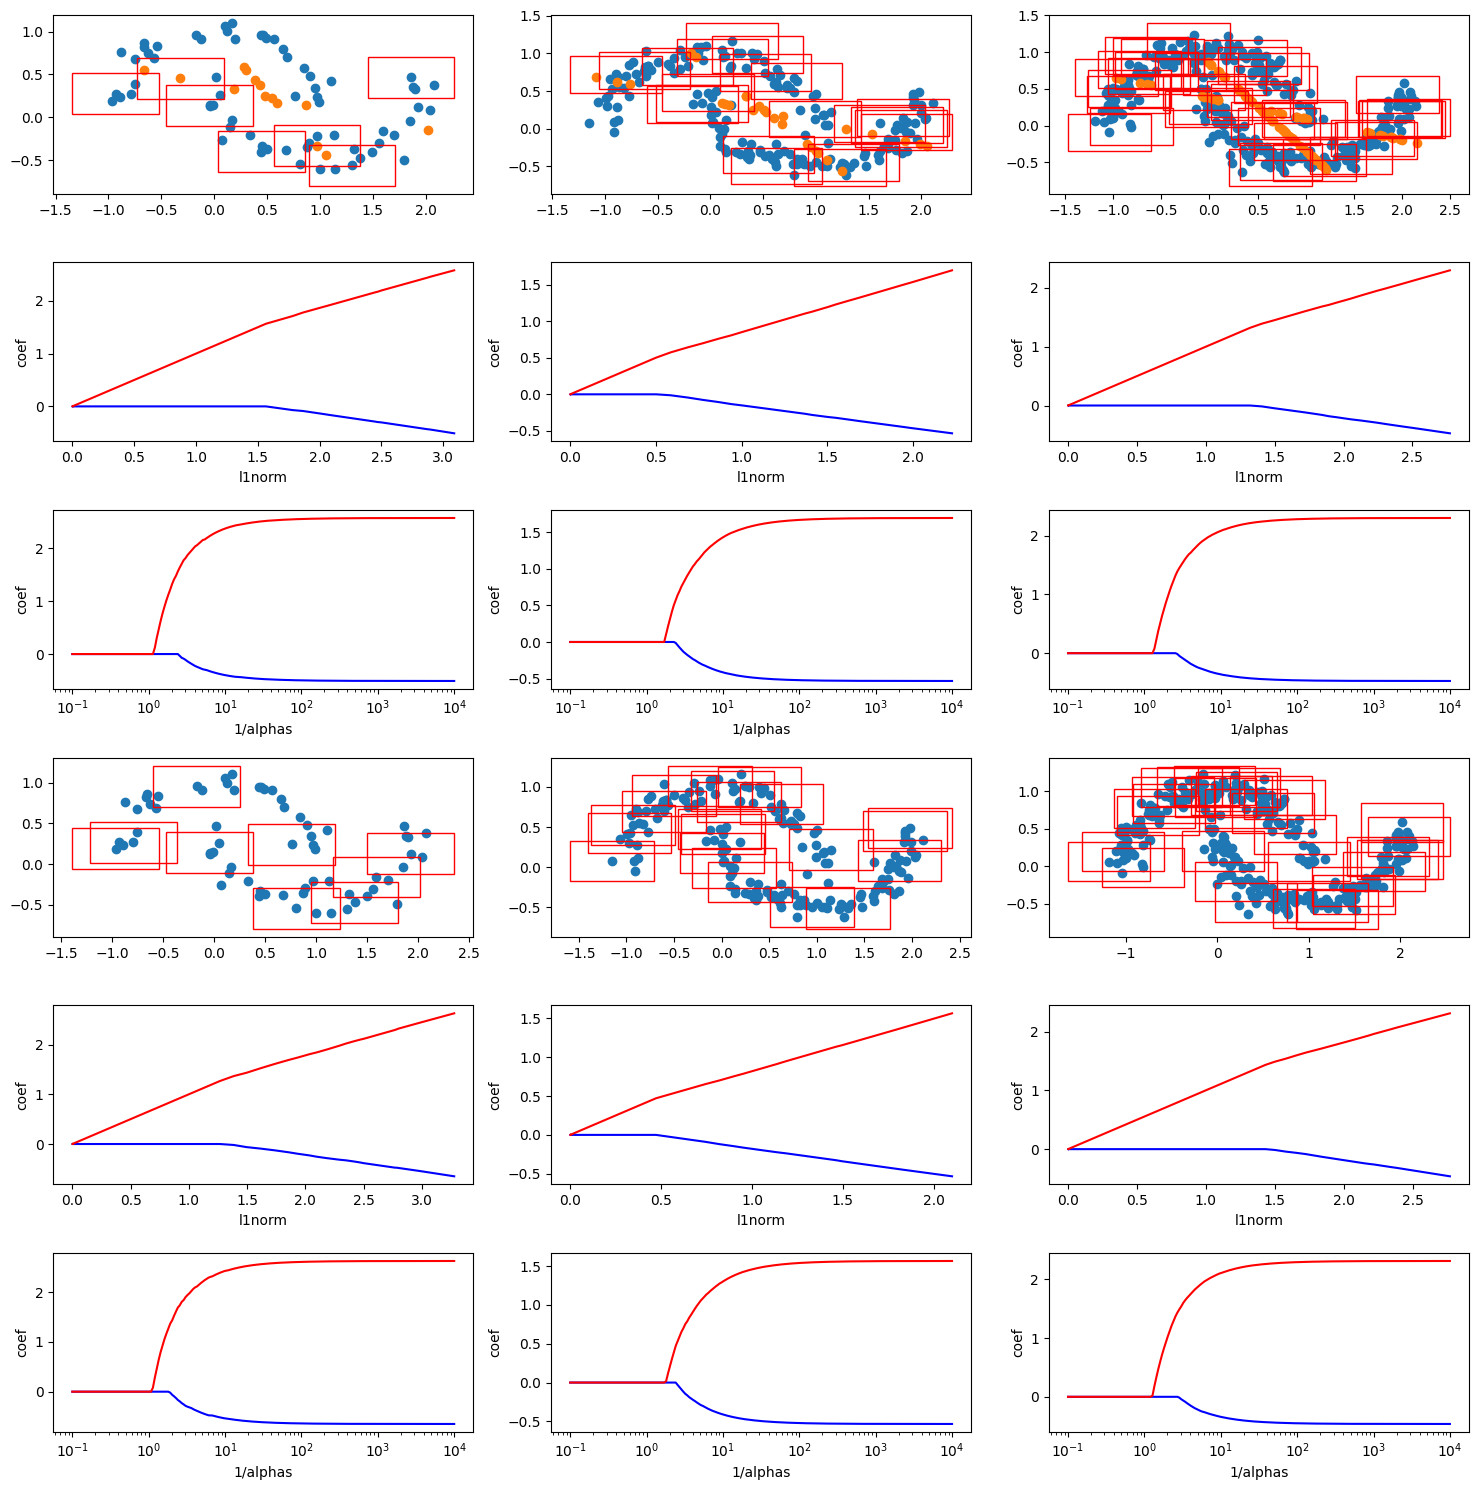

In [164]:
np.random.seed(47)  # 43
n_tot = [100, 250, 500]  # 750, 1000, 2000
ll = len(n_tot)
data = ['moons'] * ll
#n_tot = [75, 100, 200]
dim = [2] * ll
beta_gt = [np.array([-0.5, 2])] * ll
perc_test = [0.2] * ll
p_miss = [[0.8, 0.1, 0.1]] * ll
err_dic = {'kind': 'Gaussian', 'scaling': 2}
err = [err_dic] * ll
dicc = {'data':data,
        'n_tot': n_tot,
        'dim': dim,
        'beta_gt': beta_gt,
        'perc_test': perc_test,
        'p_miss': p_miss,
        'err': err}

dicc_imp1 = {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
#dicc_imp2 = {'imp_method': 'mi', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'listwise_deletion', 'cov_strategy': 'sd'}
list_methods_strategy = [dicc_imp1, dicc_imp2]
print(dicc)

run_experiments(dicc, list_methods_strategy)


{'data': ['moons', 'moons', 'moons'], 'n_tot': [500, 1000, 1500], 'dim': [2, 2, 2], 'beta_gt': [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])], 'perc_test': [0.2, 0.2, 0.2], 'p_miss': [[0.8, 0.1, 0.1], [0.8, 0.1, 0.1], [0.8, 0.1, 0.1]], 'err': [{'kind': 'Gaussian', 'scaling': 2}, {'kind': 'Gaussian', 'scaling': 2}, {'kind': 'Gaussian', 'scaling': 2}]}
--------> iteration  0
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
nbr components without missing entries  325.0
dict imp ----->  {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
-------> size train:  400  size test:  100
M size  400
M  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1
 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1

100%|██████████| 200/200 [00:02<00:00, 72.08it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (100, 2)
shape coeff  (2, 200)
shape y  (100,)
size haty  (200, 100)
size r  (200, 100)
size score  200
i_min  91
best predictor, coeff i_min 
best coeff  [-0.44160208  2.07706023]
min score  3.8089323660714878
nbr components without missing entries  325.0
dict imp ----->  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
fin res shape (1, 400, 2)
fin res shape (400, 2)
-------> size train:  400  size test:  100
M size  400
M  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1
 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0

100%|██████████| 200/200 [00:02<00:00, 75.21it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (100, 2)
shape coeff  (2, 200)
shape y  (100,)
size haty  (200, 100)
size r  (200, 100)
size score  200
i_min  0
best predictor, coeff i_min 
best coeff  [-0.48431086  1.95522738]
min score  3.8097176275669487
--------> iteration  1
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
nbr components without missing entries  634.0
dict imp ----->  {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
-------> size train:  800  size test:  200
M size  800
M  [0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1

100%|██████████| 200/200 [00:06<00:00, 30.21it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (200, 2)
shape coeff  (2, 200)
shape y  (200,)
size haty  (200, 200)
size r  (200, 200)
size score  200
i_min  75
best predictor, coeff i_min 
best coeff  [-0.46700015  2.04672322]
min score  3.8643121483455745
nbr components without missing entries  634.0
dict imp ----->  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
fin res shape (1, 800, 2)
fin res shape (800, 2)
-------> size train:  800  size test:  200
M size  800
M  [0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0

100%|██████████| 200/200 [00:05<00:00, 35.96it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (200, 2)
shape coeff  (2, 200)
shape y  (200,)
size haty  (200, 200)
size r  (200, 200)
size score  200
i_min  0
best predictor, coeff i_min 
best coeff  [-0.46756968  1.9759985 ]
min score  3.8768648947678432
--------> iteration  2
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
nbr components without missing entries  946.0
dict imp ----->  {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
-------> size train:  1200  size test:  300
M size  1200
M  [0 0 0 ... 0 0 0]
----------->  [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[0.81343863 0.        ]
 [0.         0.47595244]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[0.81 0.00]
 [0.00 0.48]] @ var8443)
ciao2
abs_error.shape  (1200,)
ciao3
ciao4


100%|██████████| 200/200 [00:07<00:00, 26.52it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (300, 2)
shape coeff  (2, 200)
shape y  (300,)
size haty  (200, 300)
size r  (200, 300)
size score  200
i_min  107
best predictor, coeff i_min 
best coeff  [-0.43911378  1.83843471]
min score  3.7849502462319515
nbr components without missing entries  946.0
dict imp ----->  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
fin res shape (1, 1200, 2)
fin res shape (1200, 2)
-------> size train:  1200  size test:  300
M size  1200
M  [0 0 0 ... 0 0 0]
----------->  [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[0.86024512 0.        ]
 [0.         0.50445597]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[0.86 0.00]
 [0.00 0.50]] @ var8510)
ciao2
abs_error.shape  (1200,)
ciao3
ciao4


100%|██████████| 200/200 [00:06<00:00, 30.42it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (300, 2)
shape coeff  (2, 200)
shape y  (300,)
size haty  (200, 300)
size r  (200, 300)
size score  200
i_min  63
best predictor, coeff i_min 
best coeff  [-0.45020786  1.81272196]
min score  3.78505970085227


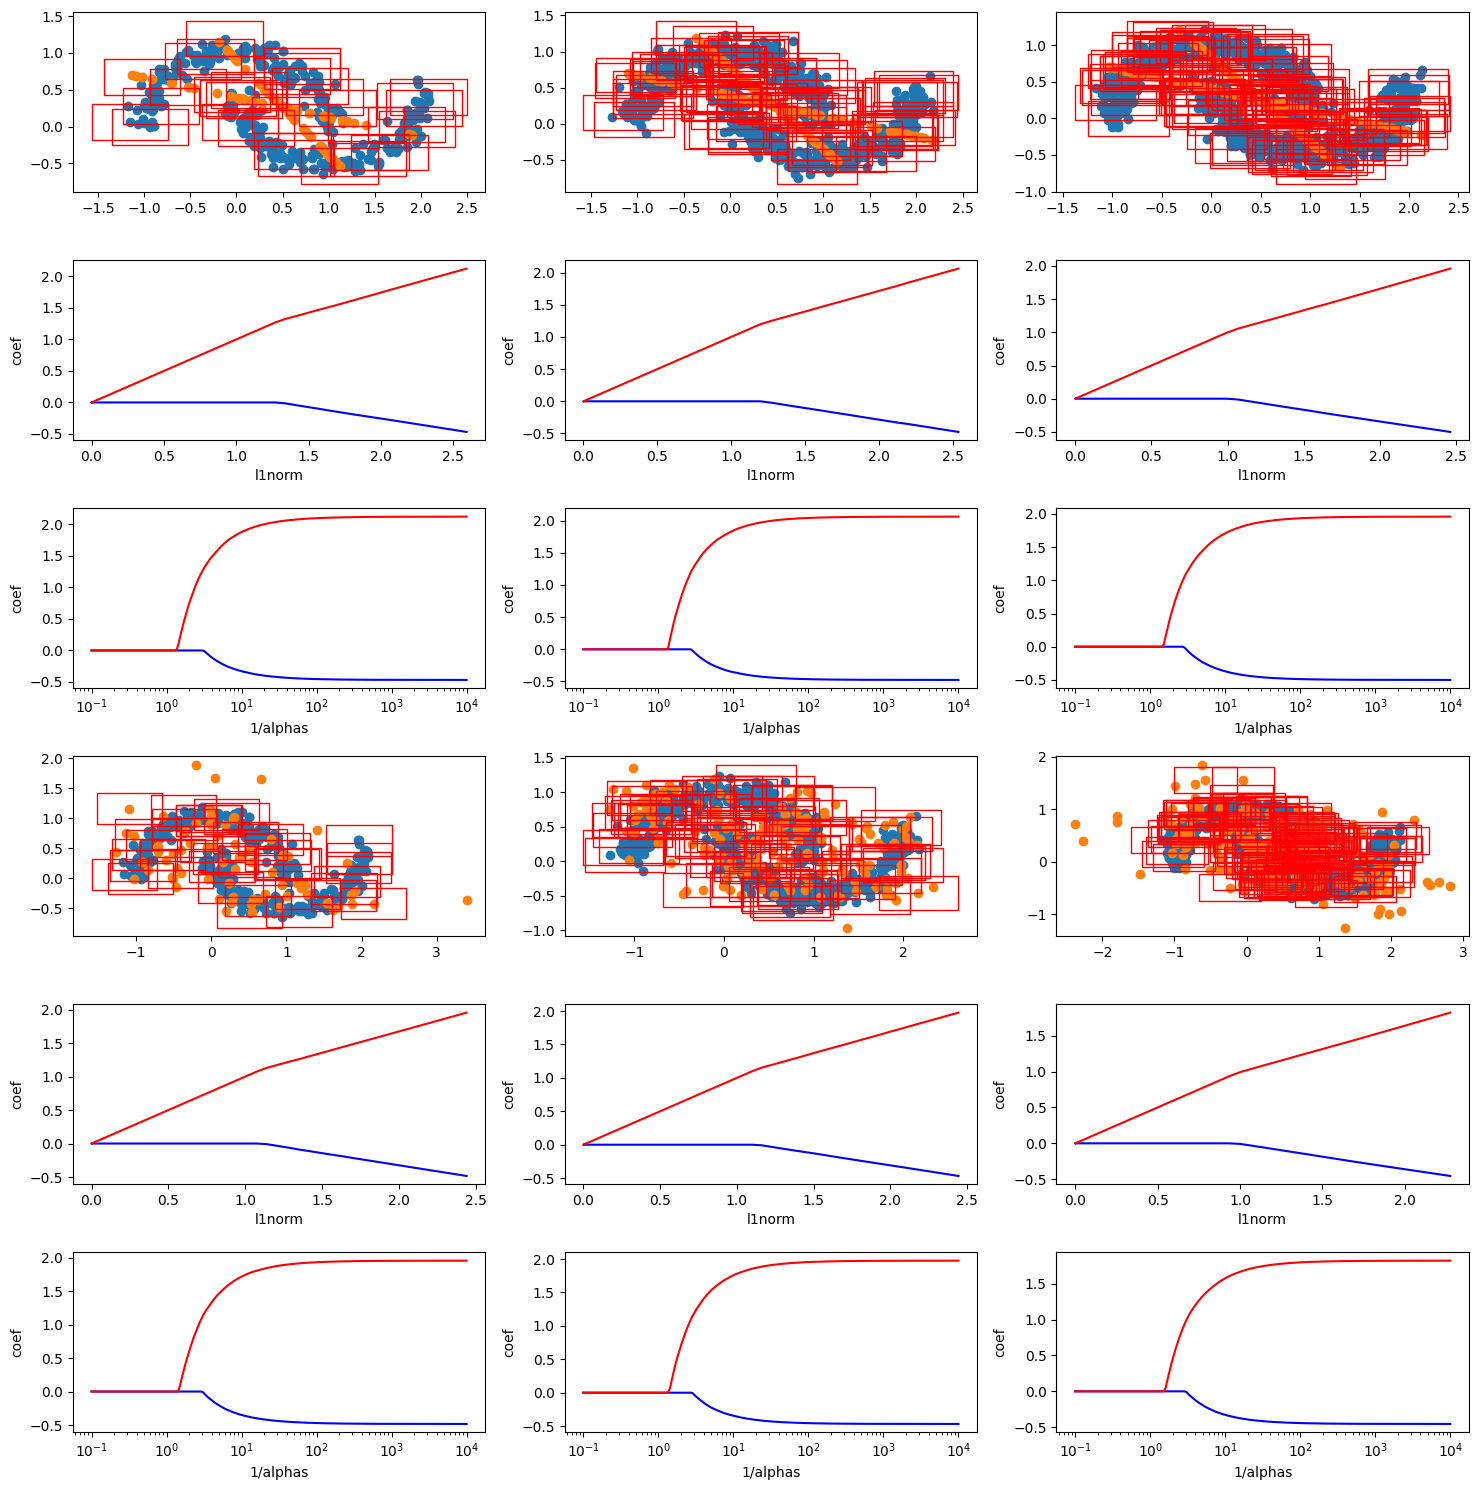

In [ ]:
np.random.seed(47)  # 43
n_tot = [500, 1000, 1500]  # 750, 1000, 2000
ll = len(n_tot)
data = ['moons'] * ll
#n_tot = [75, 100, 200]
dim = [2] * ll
beta_gt = [np.array([-0.5, 2])] * ll
perc_test = [0.2] * ll
p_miss = [[0.8, 0.1, 0.1]] * ll
err_dic = {'kind': 'Gaussian', 'scaling': 2}
err = [err_dic] * ll
dicc = {'data':data,
        'n_tot': n_tot,
        'dim': dim,
        'beta_gt': beta_gt,
        'perc_test': perc_test,
        'p_miss': p_miss,
        'err': err}

dicc_imp1 = {'imp_method': 'BayesianRidge_single_imp', 'cov_strategy': 'sd'}
#dicc_imp2 = {'imp_method': 'mi', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
list_methods_strategy = [dicc_imp1, dicc_imp2]
print(dicc)

run_experiments(dicc, list_methods_strategy)


ground truth  [-0.5  2. ]
--------> iteration  0


TypeError: 'float' object is not subscriptable

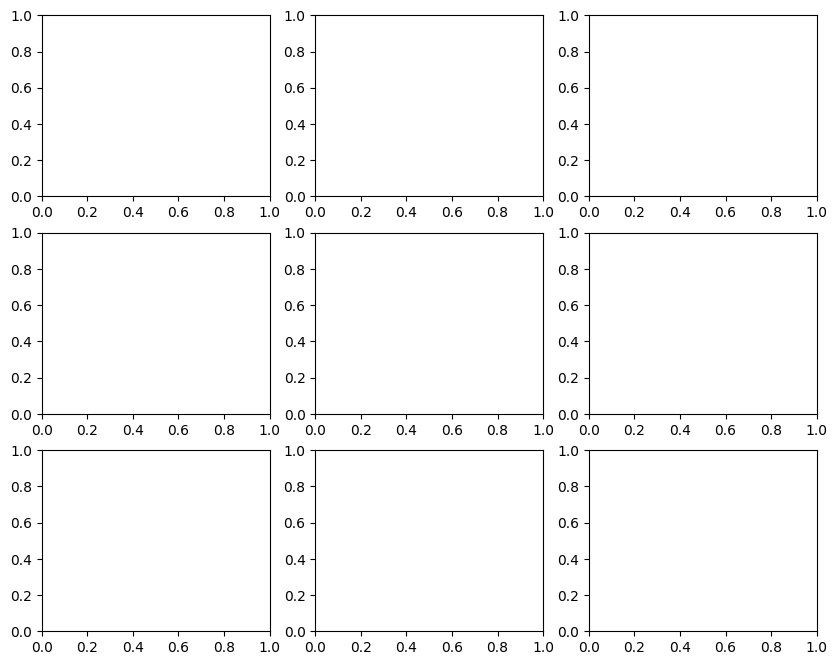

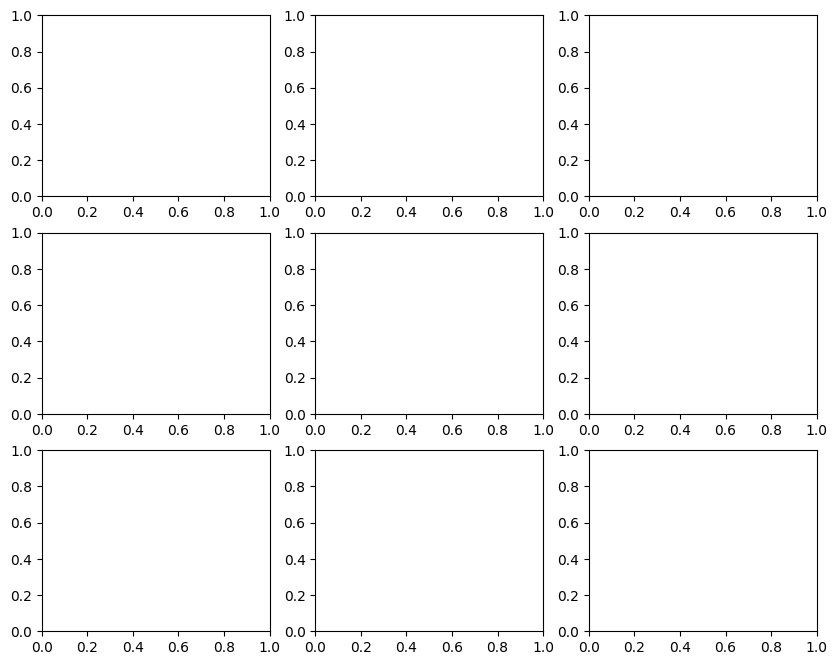

In [ ]:
np.random.seed(43)
list_tot = [750, 1000, 2000]  # 750, 1000, 2000
l = len(list_tot)
p_miss_2d = [0.1, 0.45, 0.45]  # 0.1, 0.45, 0.45
beta_2d = np.array([-0.5, 2])
print("ground truth ", beta_2d)
scores_fin = np.zeros(l)
coeff_fin = np.zeros((2, l))
scores_fin_ld = np.zeros(l)
coeff_fin_ld = np.zeros((2, l))

p_test = 0.2  # 0.2
err_2d = 2.5  # 5
fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d_mi')
fig1, ax1 = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d_mi1')

# test with imputation by multiple imputation

number_multiple_imputed_datasets = 1


for i in range(l):
    print("--------> iteration ", i)
    n_total = list_tot[i]
    dict_obser = generate_dataset(data='Gaussian', n_tot=n_total, dim=2, beta_gt=beta_2d, perc_test=p_test, p_miss=p_miss_2d, err=err_2d)
    best_coeff_round, min_score_round = experiment_2d_ext_dataset(dict_obser, ax[:, i])
    print("best coeff ", best_coeff_round, "\n min score ", min_score_round)
    coeff_fin[:, i] = best_coeff_round
    scores_fin[i] = min_score_round
    #print(dict_obser)
    # deep_copied = copy.deepcopy(original)
    dict_obser['X_train'] = listwise_delection(dict_obser['X_train'], dict_obser['masks_train'])
    dict_obser['y_train'] = listwise_delection(dict_obser['y_train'], dict_obser['masks_train'])
    dict_obser['masks_train'] = np.zeros_like(dict_obser['X_train'])
    #print(dict_obser)
    best_coeff_round_ld, min_score_round_ld = experiment_2d_ext_dataset(dict_obser, ax1[:, i])
    coeff_fin_ld[:, i] = best_coeff_round_ld
    scores_fin_ld[i] = min_score_round_ld

print("final coeff \n", coeff_fin.T)
print("final scores \n ", scores_fin)

print("final coeff \n", coeff_fin_ld.T)
print("final scores \n ", scores_fin_ld)





X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)










In [ ]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


In [ ]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

In [ ]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


In [ ]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)


In [ ]:
# mi bayesian ridge

number_multiple_imputed_datasets = 1
X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)

fig, ax = plt.subplots(num='advtrain_linf_mi')
linfadvtrain_mi = AdversarialTraining(X_mi, yy, S_inv_mi, p=np.inf)
estimator_mi = lambda X, y, a:  linfadvtrain_mi(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mi  = get_path(X_mi, yy, estimator_mi, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mi, ax)





NameError: name 'X_nan' is not defined

end block


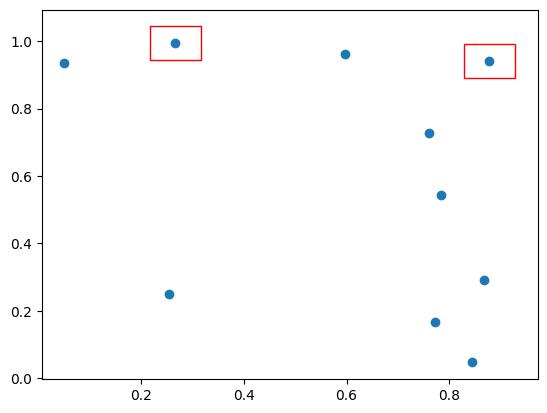

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


[2 1 9 2 8 9 4 8 9 5]
2
[[2 1 9 2 8]
 [9 4 8 9 5]]
10
4.0
4.0
[1 0 1 1 0 0 1 0 1 0]
mm
  (array([[ 1.72083439, -0.0908867 ],
       [ 1.92068747,  0.60608137],
       [ 0.87116014,  0.64154888],
       [-0.57016801,  0.53104892],
       [-0.96103996, -0.12285985],
       [ 0.09425685,  1.0860456 ],
       [ 0.50063122, -0.06497848],
       [ 0.98342288, -0.60817475],
       [ 1.05656871, -0.00607314],
       [ 0.1551155 ,  0.28336192]]), array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1]))


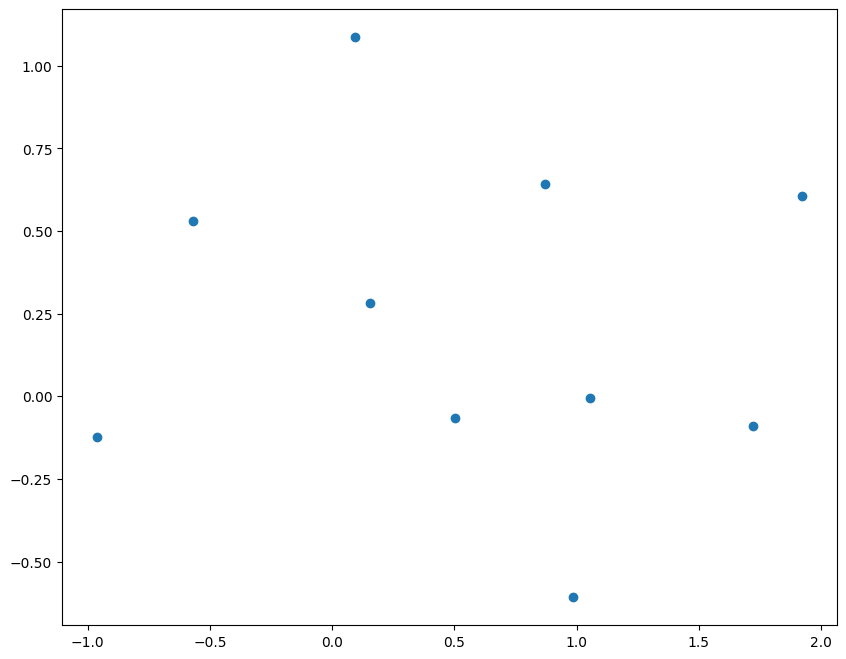

In [ ]:
from sklearn.datasets import make_moons

figt, axt = plt.subplots(1, 1, figsize=(10, 8), num='advtrain_linf_2d')

x = np.random.randint(1, 10, size=10)
print(x)
xx = np.reshape(x, (2, 5), order='C')
print(xx.shape[0])
print(np.reshape(x, (2, 5), order='C'))
print(x.size)
print(np.floor(5 * 0.8))
print(np.floor(5 * 0.8))

bb = np.random.binomial(1, 0.5, size=10)
print(bb)
mm = make_moons(10, noise=0.1)
print("mm\n ", mm)
axt.scatter(mm[0][:, 0], mm[0][:, 1])


test generate_X started
(1000, 2)
test generate passed syccessfully

test preparation dataset started
X_train 
 [[0.24919806 0.4890504  0.56823278 0.24129105]
 [0.56348306 0.02852703 0.38837174 0.03114655]
 [0.36885293 0.48882556 0.91535099 0.69506557]]
mask, 0 seen, 1 missing 
  [[0 0 0 1]
 [0 1 1 0]
 [1 0 0 0]]
X_masked 
 [[0.24919806 0.4890504  0.56823278 0.        ]
 [0.56348306 0.         0.         0.03114655]
 [0.         0.48882556 0.91535099 0.69506557]]
X_nan_train 
 [[0.24919806 0.4890504  0.56823278        nan]
 [0.56348306        nan        nan 0.03114655]
 [       nan 0.48882556 0.91535099 0.69506557]]
X_br_train
  [[0.24919806 0.4890504  0.56823278 0.4129091 ]
 [0.56348306 0.48921243 0.09859812 0.03114655]
 [0.01694025 0.48882556 0.91535099 0.69506557]]
what happens if we run single_imputation of full dataset
X_br_full
  [[0.24919806 0.4890504  0.56823278 0.24129105]
 [0.56348306 0.02852703 0.38837174 0.03114655]
 [0.36885293 0.48882556 0.91535099 0.69506557]]
test prepa

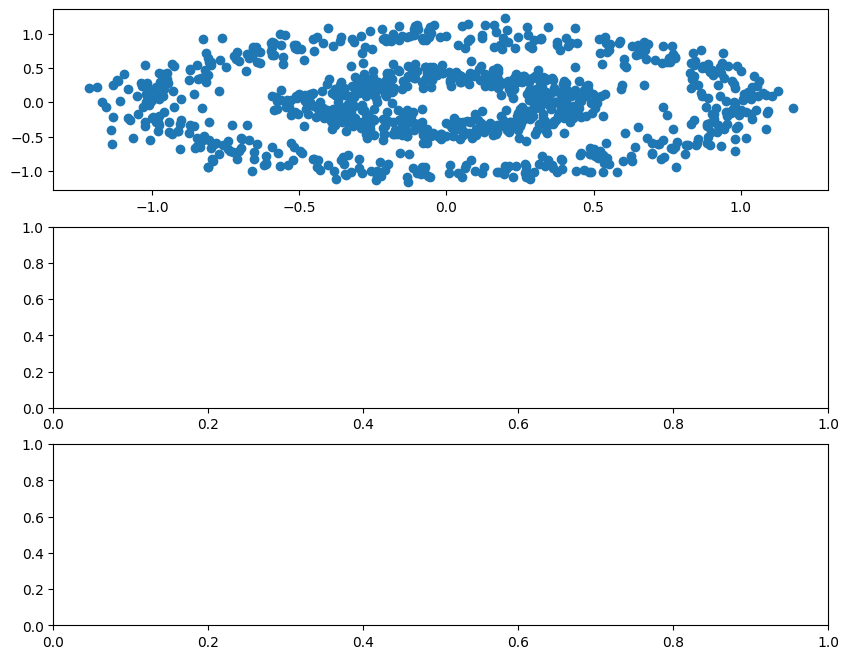

In [165]:
def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [166]:
# test best predictor
def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




[1]
best coeff  [3 4 4 4 1]
best score  135.73
test best predictor passed


you are printing coeff in function of l1 norm
who is q  1
one matrix in input, S_inv.shape = (n, n)


100%|██████████| 200/200 [00:05<00:00, 37.28it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
who is q  1
multiple matrices in input, S_inv conc


100%|██████████| 200/200 [00:42<00:00,  4.74it/s]

you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas


array([[-4.41239643e-01, -4.39156416e-01, -4.36954825e-01, ...,
         2.55903818e-12,  2.33516080e-12,  2.07416157e-12],
       [-1.13752331e+01, -1.13733491e+01, -1.13713528e+01, ...,
         7.22898920e-13,  7.12087448e-13,  6.76154771e-13],
       [ 2.47408249e+01,  2.47416756e+01,  2.47425769e+01, ...,
         7.96772727e-12,  7.53059300e-12,  6.96425326e-12],
       ...,
       [ 7.99008445e+00,  7.96434602e+00,  7.93708236e+00, ...,
         5.56538342e-12,  5.31090702e-12,  4.97148230e-12],
       [ 3.48477659e+01,  3.47949398e+01,  3.47389772e+01, ...,
         7.68269907e-12,  7.16954793e-12,  6.53865357e-12],
       [ 3.21153524e+00,  3.21122739e+00,  3.21090282e+00, ...,
         4.90836552e-12,  4.63328407e-12,  4.28278289e-12]])

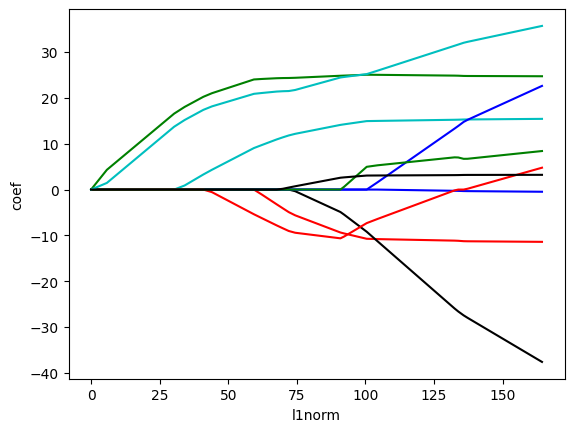

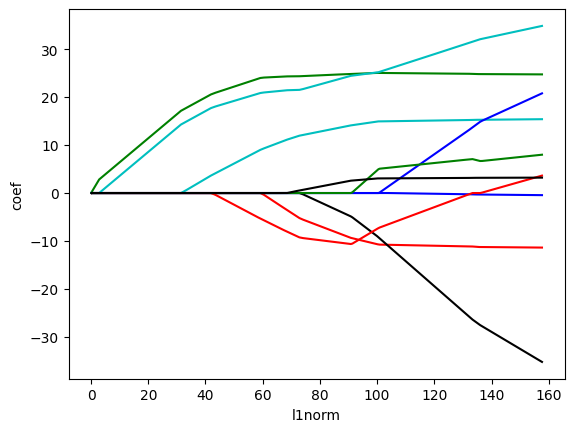

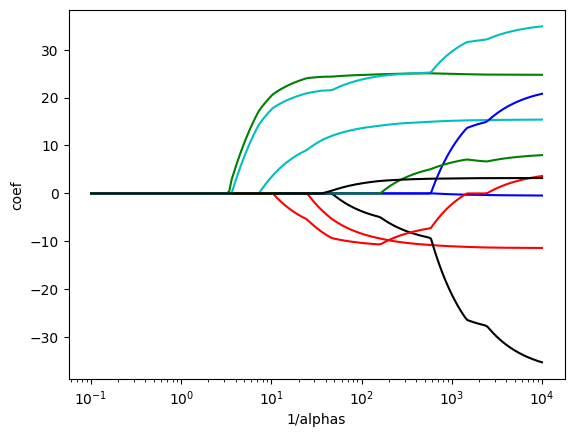

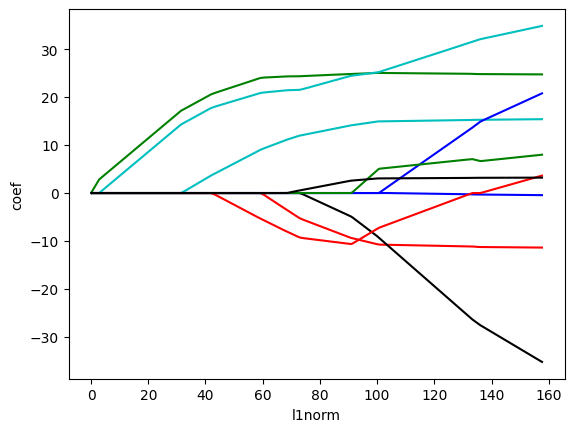

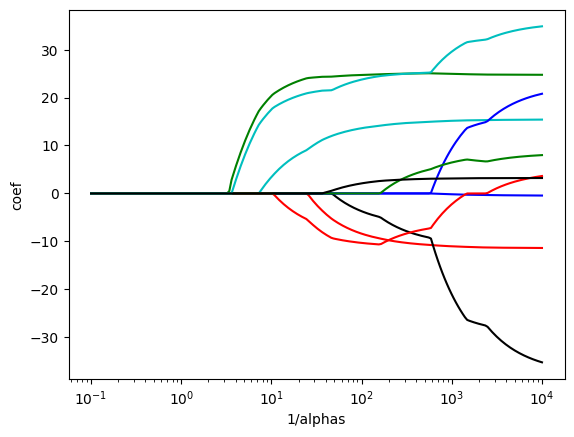

In [167]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_inv_diab = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_inv_diab, [ax_1, ax_2])

## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_inv_diab_stacked = np.array([S_inv_diab] * X_diab.shape[0])
S_inv_diab_stacked = np.concatenate(S_inv_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_inv_diab_stacked, [ax_3, ax_4])




In [168]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BayesianRidge_single_imp', 'mi', 'listwise_deletion']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")


test_imputations(6, 3)

m original
 [[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
[[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
X
  [[4. 2. 2.]
 [3. 3. 2.]
 [3. 2. 3.]
 [4. 3. 3.]
 [4. 2. 4.]
 [2. 3. 2.]]
masks 
 [[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
X_nan
  [[nan nan  2.]
 [ 3. nan  2.]
 [nan  2. nan]
 [ 4.  3.  3.]
 [ 4. nan nan]
 [nan  3. nan]]
---------- method:  BayesianRidge_single_imp
[[3.6655945  2.66443243 2.        ]
 [3.         2.66258227 2.        ]
 [3.65923039 2.         0.01456084]
 [4.         3.         3.        ]
 [4.         2.66652472 2.0034846 ]
 [3.66880864 3.         3.00274305]] [ 8.  8.  8. 10. 10.  7.] 
 [[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
---------- method:  mi
-------------------- nbr mi:  1
[[2.98022463 2.90457585 2.        ]
 [3.         4.05540778 2.        ]
 [3.20465199 2.         2.23294046]
 [4.         3.         3.        ]
 [4.         0.30437093 3.04480992]
 [3.02737436 3.         2.04467484]] [ 8.  8.  8. 10. 10.  